#Importing DataSet

In [1]:
import os
import pandas as pd

def load_emails(folder_path, label):
  data = []

  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    if os.path.isdir(file_path):
            continue

    with open(file_path, 'r', encoding='latin-1') as f:
      content = f.read()
      data.append((content, label))
  return data

0 - ham <br>
1 - spam

In [3]:
ham_path = "/content/drive/MyDrive/Colab Notebooks/spam detection/easy_ham"
spam_path = "/content/drive/MyDrive/Colab Notebooks/spam detection/spam"

ham_data = load_emails(ham_path, 0)
spam_data = load_emails(spam_path, 1)

df = pd.DataFrame(ham_data + spam_data, columns=["text", "label"])
df.head()

,text,label
0,From rpm-list-admin@freshrpms.net Mon Sep 30 ...,0
1,Return-Path: nas@python.ca\nDelivery-Date: Fri...,0
2,From spamassassin-talk-admin@lists.sourceforge...,0
3,Return-Path: tim.one@comcast.net\nDelivery-Dat...,0
4,From spamassassin-talk-admin@lists.sourceforge...,0


#Data Visualisation and Analysis

In [4]:
df.shape

(3002, 2)

In [5]:
df.describe()

,label
count,3002.000000
mean,0.166889
std,0.372939
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
df['label'].value_counts()

,count
label,
0,2501
1,501


In [7]:
df['label'].value_counts(normalize=True)

,proportion
label,
0,0.833111
1,0.166889


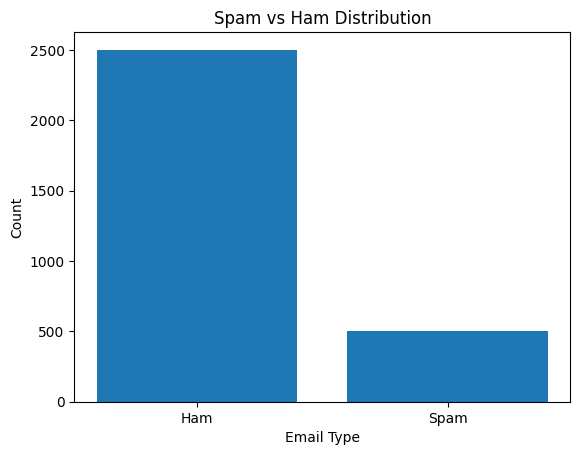

In [21]:
import matplotlib.pyplot as plt

counts = df['label'].value_counts()

plt.figure()
plt.bar(['Ham', 'Spam'], counts)
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Spam vs Ham Distribution')
plt.show()

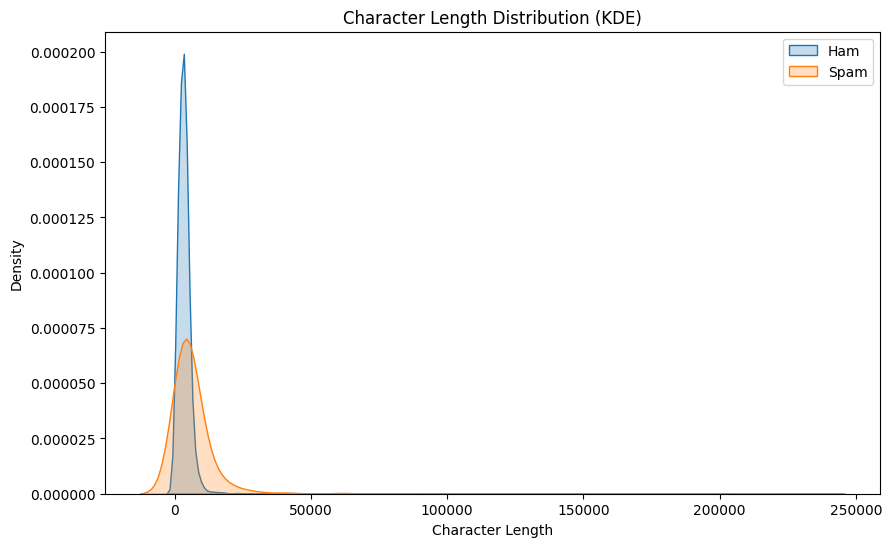

In [22]:
import seaborn as sns

df['char_length'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

ham = df[df['label'] == 0]['char_length']
spam = df[df['label'] == 1]['char_length']

plt.figure(figsize=(10, 6))
sns.kdeplot(ham, label='Ham', fill=True, common_norm=False)
sns.kdeplot(spam, label='Spam', fill=True, common_norm=False)

plt.xlabel('Character Length')
plt.ylabel('Density')
plt.title('Character Length Distribution (KDE)')
plt.legend()
plt.show()

In [23]:
df['url_count'] = df['text'].astype(str).str.count(r'http|https')
df['exclamation_count'] = df['text'].astype(str).str.count(r'\!')
df['uppercase_ratio'] = df['text'].astype(str).apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

ham_url = df[df['label'] == 0]['url_count']
spam_url = df[df['label'] == 1]['url_count']

ham_exclamation = df[df['label'] == 0]['exclamation_count']
spam_exclamation = df[df['label'] == 1]['exclamation_count']

ham_uppercase = df[df['label'] == 0]['uppercase_ratio']
spam_uppercase = df[df['label'] == 1]['uppercase_ratio']

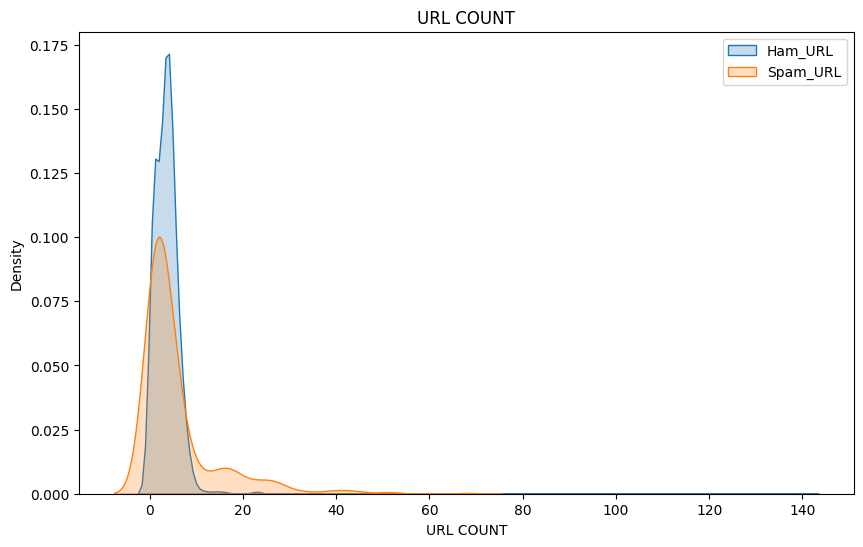

In [24]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ham_url, label='Ham_URL', fill=True, common_norm=False)
sns.kdeplot(spam_url, label='Spam_URL', fill=True, common_norm=False)

plt.xlabel('URL COUNT')
plt.ylabel('Density')
plt.title('URL COUNT')
plt.legend()
plt.show()


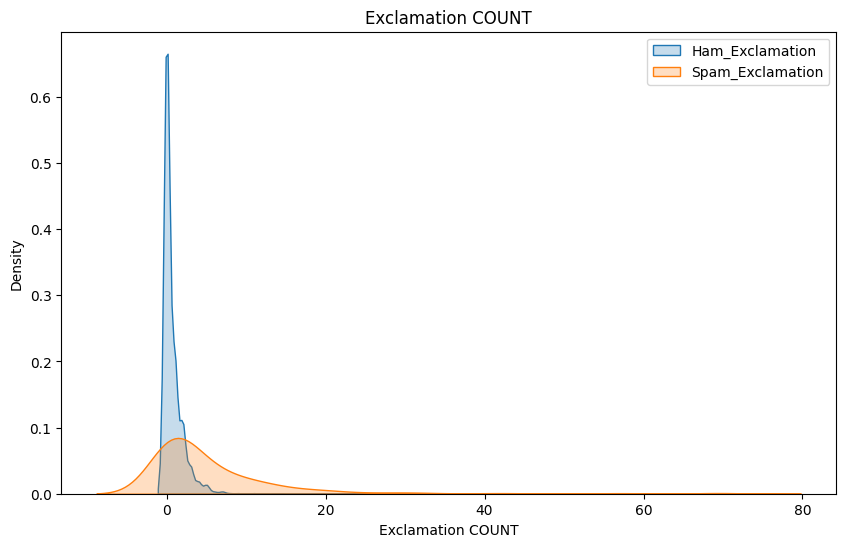

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ham_exclamation, label='Ham_Exclamation', fill=True, common_norm=False)
sns.kdeplot(spam_exclamation, label='Spam_Exclamation', fill=True, common_norm=False)

plt.xlabel('Exclamation COUNT')
plt.ylabel('Density')
plt.title('Exclamation COUNT')
plt.legend()
plt.show()

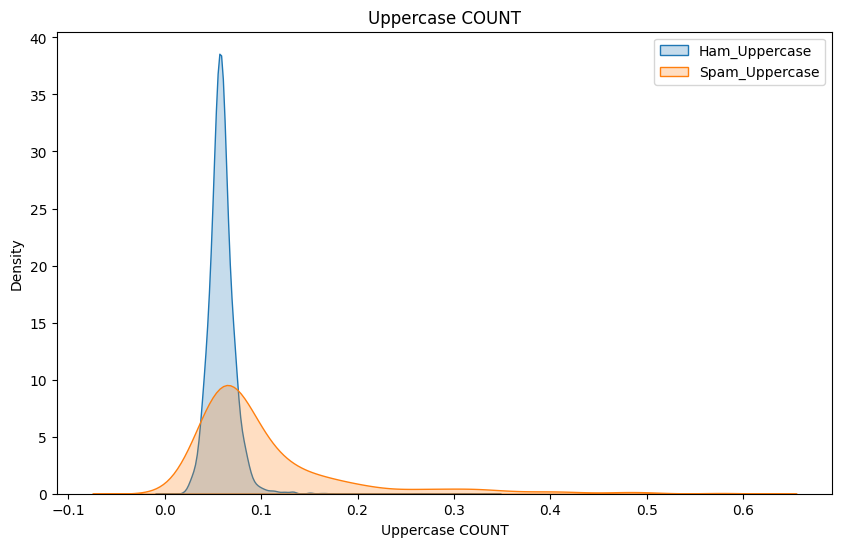

In [26]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ham_uppercase, label='Ham_Uppercase', fill=True, common_norm=False)
sns.kdeplot(spam_uppercase, label='Spam_Uppercase', fill=True, common_norm=False)

plt.xlabel('Uppercase COUNT')
plt.ylabel('Density')
plt.title('Uppercase COUNT')
plt.legend()
plt.show()

In [27]:
spam_text = " ".join(df[df['label'] == 1]['text'].astype(str))
ham_text = " ".join(df[df['label'] == 0]['text'].astype(str))

import re
def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  return text

spam_text = clean_text(spam_text)
ham_text = clean_text(ham_text)

from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopwords = set(ENGLISH_STOP_WORDS)

def get_top_words(text, n=20):
  words = text.split()
  words = [word for word in words if word not in stopwords and len(word) > 2]
  return Counter(words).most_common(n)

spam_top = get_top_words(spam_text)
ham_top = get_top_words(ham_text)

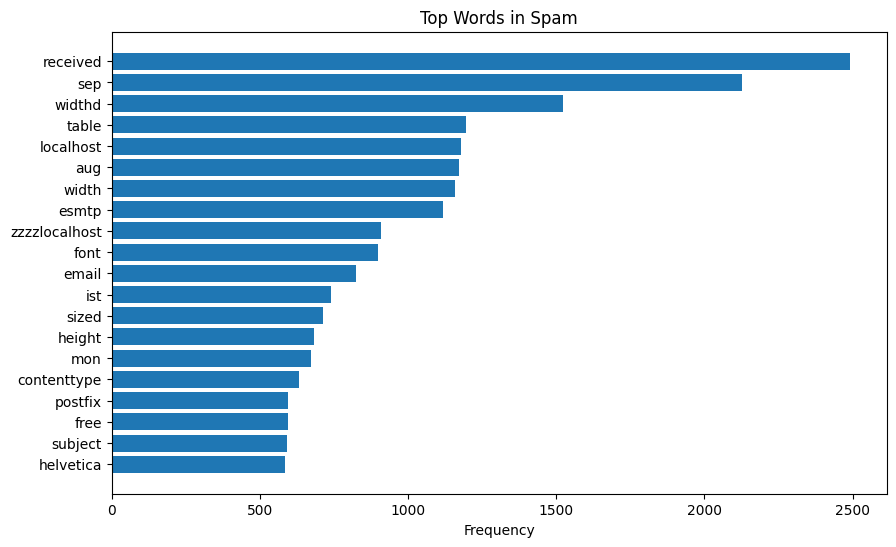

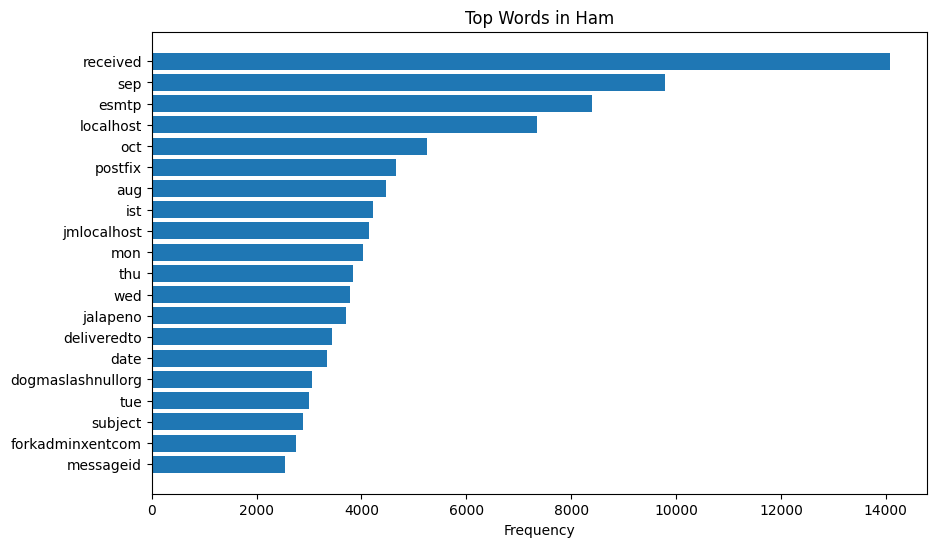

In [28]:
def plot_top_words(word_list, title):
  words = [w[0] for w in word_list]
  counts = [w[1] for w in word_list]

  plt.figure(figsize=(10, 6))
  plt.barh(words, counts)
  plt.gca().invert_yaxis()
  plt.title(title)
  plt.xlabel("Frequency")
  plt.show()

plot_top_words(spam_top, "Top Words in Spam")
plot_top_words(ham_top, "Top Words in Ham")

<Axes: >

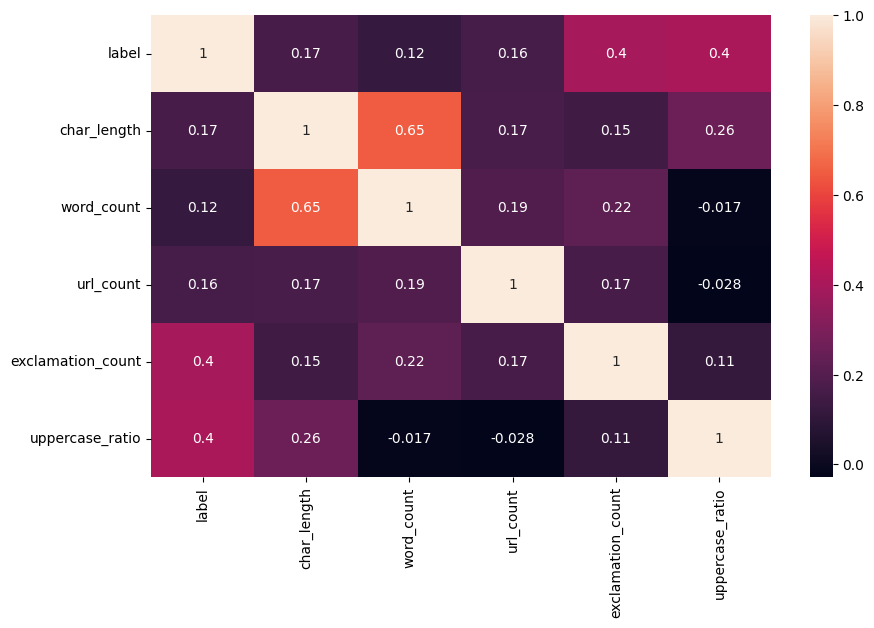

In [29]:
corr_matrix = df.select_dtypes(include="number").corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True)

# MODEL

In [8]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    lowercase = True,
    stop_words = 'english',
    binary = False # false => word counts || true => presence only
)

In [10]:
X_train_vectors = vectorizer.fit_transform(X_train)

In [12]:
X_train_vectors

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 507671 stored elements and shape (2401, 85991)>

In [13]:
X_test_vectors = vectorizer.transform(X_test)

In [14]:
vectorizer.vocabulary_

{'fork': 43116,
 'admin': 24360,
 'xent': 82735,
 'com': 33138,
 'fri': 43437,
 'sep': 72209,
 '20': 9100,
 '11': 6281,
 '32': 12307,
 '30': 12069,
 '2002': 9122,
 'return': 70028,
 'path': 64749,
 'delivered': 36168,
 'yyyy': 84212,
 'localhost': 57639,
 'spamassassin': 73654,
 'taint': 75539,
 'org': 63651,
 'received': 69221,
 'jalapeno': 53981,
 '127': 6571,
 'jmason': 54464,
 'postfix': 66403,
 'esmtp': 40679,
 'id': 51602,
 'a7a0316f03': 23284,
 'jm': 54450,
 '29': 11331,
 '0100': 2314,
 'ist': 53488,
 'imap': 52281,
 'fetchmail': 42337,
 'single': 72887,
 'drop': 37950,
 '64': 17198,
 '161': 7125,
 '22': 10428,
 '236': 10701,
 'dogma': 37365,
 'slashnull': 73088,
 'g8jhlgc29973': 45859,
 'thu': 76310,
 '19': 8285,
 '18': 8103,
 '21': 10310,
 '43': 14181,
 'lair': 56509,
 'ebfb229410c': 39236,
 '10': 5694,
 '05': 4581,
 '0700': 4737,
 'pdt': 65053,
 'panacea': 64531,
 'canonical': 31279,
 'ns1': 62352,
 '209': 10247,
 '115': 6353,
 '72': 18359,
 'b0d0329409c': 27136,
 '17': 7242,

In [15]:
vectorizer.get_feature_names_out()[:20]

array(['00', '000', '0000', '000000', '000000000',
       '000000000000000000000', '00000053', '00000073', '00000094',
       '000000c958bd', '0000015d', '000001c249ff', '000001c259c0',
       '000001c26e44', '00000254', '000003d2', '0000047b4e66', '00000530',
       '00000582', '0000059b'], dtype=object)

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train_vectors, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [18]:
y_pred = model.predict(X_test_vectors)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[501   0]
 [  0 100]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       501
           1       1.00      1.00      1.00       100

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



In [20]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

top_spam_words = np.argsort(coefficients)[-20:]
top_ham_words = np.argsort(coefficients)[:20]

print("Top Spam Words:")
print(feature_names[top_spam_words])

print("\nTop Ham Words:")
print(feature_names[top_ham_words])

Top Spam Words:
['microsoft' 'dec' 'lerami' '14' 'webmaster' '15' 'newnamedns' 'social'
 'sat' 'priority' 'received' 'click' 'lerctr' 'money' '3d' 'free'
 'webnote' 'zzzzason' 'smtp' 'zzzz']

Top Ham Words:
['netnoteinc' 'rssfeeds' 'date' 'spamassassin' 'jm' 'spambayes' 'tim'
 'oct' 'comcast' '0000' 'yahoogroups' 'spam' 'skip' 'zzzzteana' 'yyyy'
 'pathname' 'eircom' '127' 'fork' 'use']
